In [1]:
import clip
import dnnlib
import legacy
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
from torchvision.utils import make_grid
import pandas as pd
import PIL 
import matplotlib.pyplot as plt
import pickle
import os
import random
import torch.optim.lr_scheduler as lrs
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

In [3]:
class MLP(torch.nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dim=256, n_hidden=3):
    super(MLP, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.n_hidden = n_hidden
    self.layers = torch.nn.ModuleList()
    self.layers.append(torch.nn.Linear(self.input_dim, self.hidden_dim))
    for i in range(self.n_hidden):
      self.layers.append(torch.nn.Linear(self.hidden_dim, self.hidden_dim))
    self.layers.append(torch.nn.Linear(self.hidden_dim, self.output_dim))

    # 1- cosine similarity loss
    self.loss = torch.nn.CosineSimilarity(dim=-1)
  # def forward(self, x):
    
  #   x = x.float()
  #   for i in range(len(self.layers)):
  #     x = self.layers[i](x)
      
  #     if(i < len(self.layers)-1):
  #       x = torch.nn.functional.relu(x)
        
  #   return x
  def forward(self, x):
    x = x.float()
    for i in range(len(self.layers)):
      x = self.layers[i](x)
      if(i < len(self.layers)-1):
        x = torch.nn.functional.relu(x)
      else:
        x = torch.nn.functional.tanh(x)
    return x

  def backward(self, clip, latent):
    y_pred = self.forward(clip)
    loss=self.loss(y_pred, latent)
   
    return 1-loss.mean()

In [6]:
try:
    MLP_path_cpu
except NameError:
    MLP_path_cpu = os.getcwd().replace("\\", "/") + '/MLP_dataset_cpu/Nueva carpeta/'

with open(MLP_path_cpu + 'clip_embeddings_cpu.pkl', 'rb') as f:
    clip_embedding= pickle.load(f)
with open(MLP_path_cpu + 'latent_vectors_cpu.pkl', 'rb') as f:
    latent_vector = pickle.load(f)

# print(type(clip_embedding_), clip_embedding_.shape)

# # put all the embeddings and latent vectors in one tensor
# clip_embedding = torch.cat(clip_embedding_)
# latent_vector = torch.cat(latent_vector_)

# MLP_path = os.getcwd().replace("\\", "/") + '/MLP_dataset_std1/'

# clip_embedding_ = []
# latent_vector_ = []
# for i in range(0, len(os.listdir(MLP_path))//2):
#     with open(MLP_path+'clip_embeddings_' + str(i) + '.pkl', 'rb') as f:
#         clip_embedding_.append(pickle.load(f))
#     with open(MLP_path+'latent_vectors_' + str(i) + '.pkl', 'rb') as f:
#         latent_vector_.append(pickle.load(f))

# # put all the embeddings and latent vectors in one tensor
# clip_embedding = torch.cat(clip_embedding_)
# latent_vector = torch.cat(latent_vector_)

dataset = torch.utils.data.TensorDataset(clip_embedding, latent_vector)

# # split the dataset into train, validation and test sets
train, val= torch.utils.data.random_split(dataset, [int(len(dataset)*0.85), int(len(dataset)*0.15)])
train_loader = torch.utils.data.DataLoader(train, batch_size=48, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=48, shuffle=True)



In [7]:

for data in train_loader:
    clip = data
    print(len(clip[0]))
    break





48


In [22]:
MLP_low_dim= os.getcwd().replace("\\", "/") + '/decoders/'

with open(MLP_low_dim + 'encoded_clip_embeddings.pkl', 'rb') as f:
    clip_embedding_encoded= pickle.load(f)
with open(MLP_low_dim + 'encoded_latent_vector.pkl', 'rb') as f:
    latent_vector_encoded = pickle.load(f)

print(type(clip_embedding_encoded), clip_embedding_encoded.shape)
dataset= torch.utils.data.TensorDataset(clip_embedding_encoded, latent_vector_encoded)



# split the dataset into train, validation and test sets
train, val= torch.utils.data.random_split(dataset, [int(len(dataset)*0.85), int(len(dataset)*0.15)])
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=64, shuffle=True)




<class 'torch.Tensor'> torch.Size([10040, 64])


4323
low dim  0.01993483304977417
before  -0.058629680424928665


Text(0.5, 1.0, 'Cosine similarity Low dim')

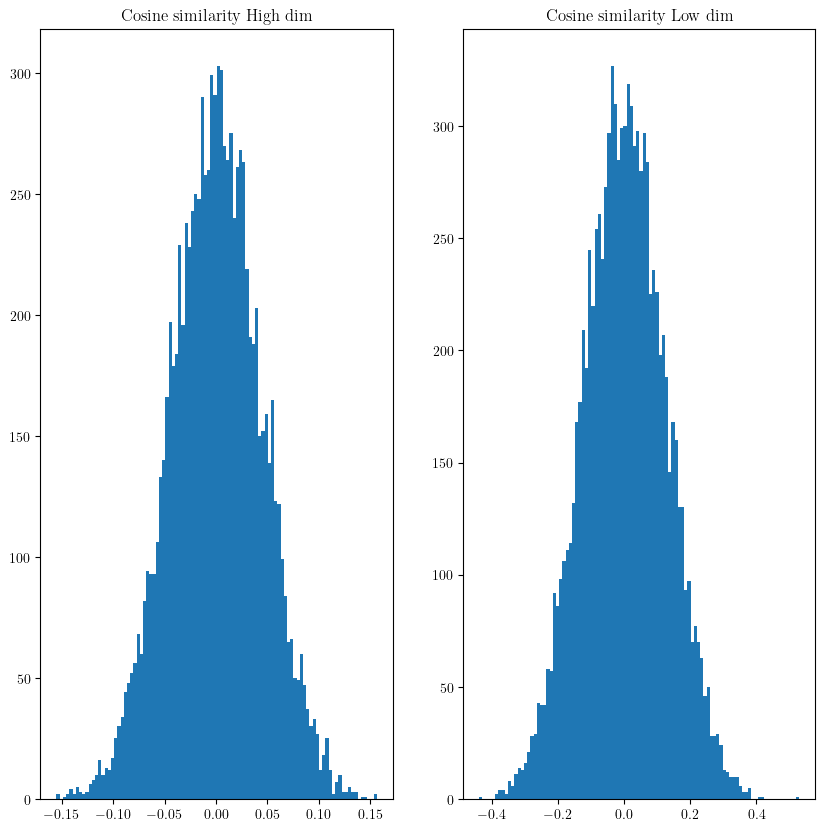

In [16]:
index=random.randint(0, len(clip_embedding_encoded)-1)
print(index)
print("low dim ",F.cosine_similarity(clip_embedding_encoded[index], latent_vector_encoded[index], dim=0).item())

print("before ",F.cosine_similarity(clip_embedding[index], latent_vector[index], dim=0).item())

#Do an histogram of the cosine similarity between the clip embeddings and the latent vectors 
#to see how many of them are similar
cosine_similarity_high_dim=[]
for i in range(len(clip_embedding)):
    cosine_similarity_high_dim.append(F.cosine_similarity(clip_embedding[i], latent_vector[i], dim=0).item())
cosine_similarity_high_dim=np.array(cosine_similarity_high_dim)
cosine_similarity_low_dim=[]
for i in range(len(clip_embedding_encoded)):
    cosine_similarity_low_dim.append(F.cosine_similarity(clip_embedding_encoded[i], latent_vector_encoded[i], dim=0).item())
cosine_similarity_low_dim=np.array(cosine_similarity_low_dim)


Text(0.5, 1.0, 'Cosine similarity ${R}^{64}$')

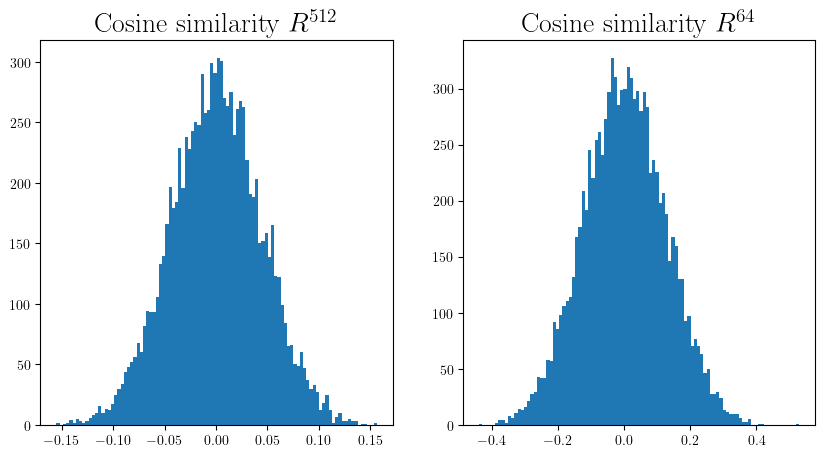

In [21]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(cosine_similarity_high_dim, bins=100)
axs[0].set_title('Cosine similarity  ${R}^{512}$',fontdict={'fontsize': 20})
axs[1].hist(cosine_similarity_low_dim, bins=100)
axs[1].set_title('Cosine similarity ${R}^{64}$',fontdict={'fontsize': 20})

In [4]:
def train_MLP(train_loader, val_loader, mlp, n_epochs=1000, batch_size=12, learning_rate=1e-3, use_cuda=True,scheduler=None):
    # Initialize optimizer
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
    if scheduler is not None: scheduler = lrs.ExponentialLR(optimizer, gamma=0.95) 
    # Initialize dataloader
    # Train MLP
    total_step = len(train_loader)
    total_step_val = len(val_loader)
    
    print("total_step: ", total_step)
    print("Starting training loop...")
    losses_train = []
    losses_val = []
    for epoch in range(n_epochs):
        loss_avg_train = 0
        for i, (clip_e, latent_v) in enumerate(train_loader):
            
            optimizer.zero_grad()
            loss = mlp.backward(clip_e, latent_v)
            loss.backward()
            optimizer.step()
            
            loss_avg_train += loss.cpu().item()  
        loss_avg_train = loss_avg_train / total_step
        losses_train.append(loss_avg_train)

        loss_avg_val = 0
        for (clip_e, latent_v) in val_loader:
            with torch.no_grad():
                loss_val = mlp.backward(clip_e, latent_v)
            
            loss_avg_val += loss_val.cpu().item()  
        loss_avg_val = loss_avg_val / total_step_val
        losses_val.append(loss_avg_val)

        if ((epoch) % 10 == 0):
            if scheduler is None:
                print ('Epoch [{}/{}], Loss Train: {:.4f} , Loss Val: {:.4f}'
                        .format(epoch, n_epochs, loss_avg_train, loss_avg_val))
            else:
                print ('Epoch [{}/{}], Loss: {:.4f}, Loss Val: {:.4f}, LR: {:.4f}'
                    .format(epoch, n_epochs, loss_avg_train, loss_avg_val, optimizer.param_groups[0]['lr']))
        if scheduler is not None: scheduler.step()
        
    return losses_train, losses_val

def test_MLP(test_loader, mlp, use_cuda=True):
    losses = []
    for i, (clip_e, latent_v) in enumerate(test_loader):
        loss = mlp.backward(clip_e, latent_v)
        losses.append(loss.cpu().item())
    print("Mean loss: ", sum(losses)/len(losses))

In [44]:
# get shape of train loader
for data in train_loader:
    print(data[0].shape)
    break

torch.Size([64, 64])


In [24]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model = MLP(64, 64,hidden_dim=256,n_hidden=1).cuda()

losses_train, losses_val=train_MLP(train_loader,val_loader=val_loader, mlp=my_model, n_epochs=500, batch_size=24, learning_rate=1e-3, use_cuda=False)


total_step:  134
Starting training loop...
Epoch [0/500], Loss Train: 0.9538 , Loss Val: 0.9105
Epoch [10/500], Loss Train: 0.6591 , Loss Val: 0.9390
Epoch [20/500], Loss Train: 0.5475 , Loss Val: 0.9551
Epoch [30/500], Loss Train: 0.4994 , Loss Val: 0.9576
Epoch [40/500], Loss Train: 0.4708 , Loss Val: 0.9641
Epoch [50/500], Loss Train: 0.4531 , Loss Val: 0.9641
Epoch [60/500], Loss Train: 0.4399 , Loss Val: 0.9652
Epoch [70/500], Loss Train: 0.4310 , Loss Val: 0.9672
Epoch [80/500], Loss Train: 0.4226 , Loss Val: 0.9690
Epoch [90/500], Loss Train: 0.4163 , Loss Val: 0.9689
Epoch [100/500], Loss Train: 0.4106 , Loss Val: 0.9710
Epoch [110/500], Loss Train: 0.4065 , Loss Val: 0.9718
Epoch [120/500], Loss Train: 0.4027 , Loss Val: 0.9717
Epoch [130/500], Loss Train: 0.3998 , Loss Val: 0.9725
Epoch [140/500], Loss Train: 0.3964 , Loss Val: 0.9719
Epoch [150/500], Loss Train: 0.3935 , Loss Val: 0.9725
Epoch [160/500], Loss Train: 0.3911 , Loss Val: 0.9720
Epoch [170/500], Loss Train: 0.38

In [8]:

MLP_path = os.getcwd().replace("\\", "/") + '/MLP_dataset_std1/'

clip_embedding_ = []
latent_vector_ = []
for i in range(0, len(os.listdir(MLP_path))//2):
    with open(MLP_path+'clip_embeddings_' + str(i) + '.pkl', 'rb') as f:
        clip_embedding_.append(pickle.load(f))
    with open(MLP_path+'latent_vectors_' + str(i) + '.pkl', 'rb') as f:
        latent_vector_.append(pickle.load(f))

# put all the embeddings and latent vectors in one tensor
clip_embedding = torch.cat(clip_embedding_)
latent_vector = torch.cat(latent_vector_)

dataset = torch.utils.data.TensorDataset(clip_embedding,latent_vector)

# split the dataset into train, validation and test sets
train, val= torch.utils.data.random_split(dataset, [int(len(dataset)*0.85), int(len(dataset)*0.15)])
train_loader = torch.utils.data.DataLoader(train, batch_size=48, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=48, shuffle=True)

total_step:  19
Starting training loop...
Epoch [0/500], Loss Train: 0.9975 , Loss Val: 0.9996
Epoch [10/500], Loss Train: 0.5748 , Loss Val: 0.9704
Epoch [20/500], Loss Train: 0.4086 , Loss Val: 0.9764
Epoch [30/500], Loss Train: 0.3432 , Loss Val: 0.9863
Epoch [40/500], Loss Train: 0.3109 , Loss Val: 0.9799
Epoch [50/500], Loss Train: 0.2914 , Loss Val: 0.9808
Epoch [60/500], Loss Train: 0.2782 , Loss Val: 0.9822
Epoch [70/500], Loss Train: 0.2674 , Loss Val: 0.9777
Epoch [80/500], Loss Train: 0.2610 , Loss Val: 0.9848
Epoch [90/500], Loss Train: 0.2546 , Loss Val: 0.9864
Epoch [100/500], Loss Train: 0.2481 , Loss Val: 0.9821
Epoch [110/500], Loss Train: 0.2448 , Loss Val: 0.9815
Epoch [120/500], Loss Train: 0.2418 , Loss Val: 0.9833
Epoch [130/500], Loss Train: 0.2382 , Loss Val: 0.9833
Epoch [140/500], Loss Train: 0.2347 , Loss Val: 0.9825
Epoch [150/500], Loss Train: 0.2330 , Loss Val: 0.9841
Epoch [160/500], Loss Train: 0.2305 , Loss Val: 0.9822
Epoch [170/500], Loss Train: 0.229

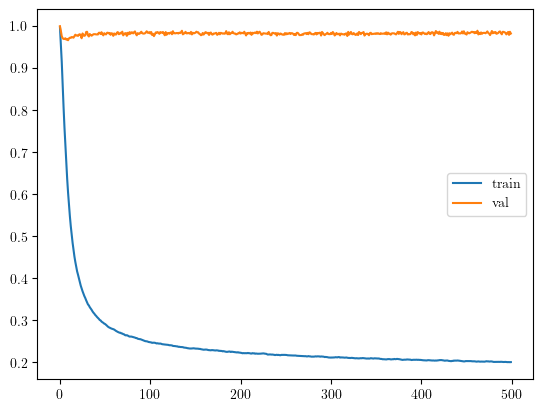

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model_512 = MLP(512, 512,hidden_dim=256,n_hidden=1).to(device)

losses_train, losses_val=train_MLP(train_loader,val_loader=val_loader, mlp=my_model_512, n_epochs=500, batch_size=48, learning_rate=1e-3, use_cuda=True)

# plot the losses
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

# save the model
torch.save(my_model_512.state_dict(), 'MLP_512_cpu.pt')

In [73]:

index = random.randint(0, len(clip_embedding_encoded)-1)

print(index)
my_model.eval()
prediction=my_model.forward(clip_embedding_encoded[index])

print("Real",F.cosine_similarity(clip_embedding_encoded[index], latent_vector_encoded[index], dim=0).item())
print("Prediction",F.cosine_similarity(prediction, latent_vector_encoded[index], dim=0).item())

#get a sample of validation data
for data in val_loader:
    clip_val, latent_val = data
    break

index=random.randint(0, len(clip_val)-1)
print(index)
print("validation data ",F.cosine_similarity(clip_val[index], latent_val[index], dim=0).item())
prediction=my_model.forward(clip_val[index])
print("prediction ",F.cosine_similarity(prediction, latent_val[index], dim=0).item())

# print(F.cosine_similarity(clip_embedding[index], latent_vector[index], dim=0).item())


# print(my_model.backward(clip_embedding[0], latent_vector[0]))
# print(my_model.backward(clip_embedding[0], prediction))

2974
Real -0.023883745074272156
Prediction 0.7812249064445496
47
validation data  0.2347104847431183
prediction  0.06313559412956238


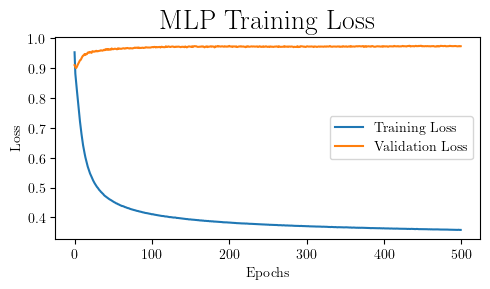

In [27]:
#save model
torch.save(my_model.state_dict(), 'clip_to_latent_64_encode.pt')

fig,ax=plt.subplots(figsize=(5,3))
ax.plot(losses_train, label='Training Loss')
ax.plot(losses_val, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('MLP Training Loss',fontdict={'fontsize': 20})
ax.legend()
fig.tight_layout()
plt.show()




In [67]:
test_MLP(test_loader, my_model, use_cuda=True)

Mean loss:  0.022173855238809034
